# STEP 2 — DATA AUDIT & RISK PROFILING

### Objective:
- Profile fraud patterns across key dimensions
- Identify high-risk segments and behavioral signals
- Generate fraud intelligence for feature engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
plt.style.use('default')
sns.set_palette("husl")

In [2]:
# Step 2A: Load Integrated Dataset


train = pd.read_parquet("../data/raw/train_merged.parquet")

print("=" * 60)
print("STEP 2A: Dataset Loaded")
print("=" * 60)
print(f"Dataset shape: {train.shape}")
print(f"Memory usage: {train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print()

STEP 2A: Dataset Loaded
Dataset shape: (590540, 434)
Memory usage: 2480.55 MB



In [13]:
# Step 2B: Global Fraud Risk Overview


print("=" * 60)
print("STEP 2B: Global Fraud Risk Overview")
print("=" * 60)

fraud_rate = train["isFraud"].mean()
fraud_count = train["isFraud"].sum()
total_count = len(train)

print(f" Fraud Base Rate: {fraud_rate:.4%}")
print(f" Fraudulent transactions: {fraud_count:,}")
print(f" Legitimate transactions: {total_count - fraud_count:,}")
print(f" Class imbalance: 1:{int(1/fraud_rate)}")
print()

STEP 2B: Global Fraud Risk Overview
 Fraud Base Rate: 3.4990%
 Fraudulent transactions: 20,663
 Legitimate transactions: 569,877
 Class imbalance: 1:28



In [4]:
# Step 2C: Transaction Amount Risk Analysis


print("=" * 60)
print("STEP 2C: Transaction Amount Risk Analysis")
print("=" * 60)


STEP 2C: Transaction Amount Risk Analysis


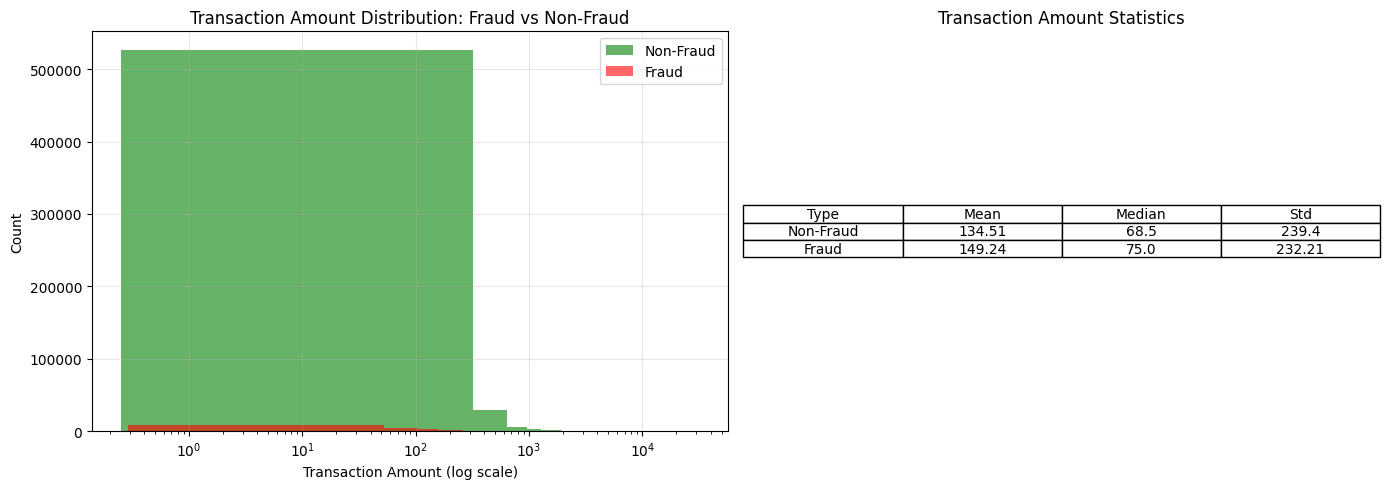

Transaction Amount Statistics by Fraud Status:
     Type       Mean  Median        Std
Non-Fraud 134.511665    68.5 239.395078
    Fraud 149.244779    75.0 232.212163



In [14]:
# Step 2C.1: Distribution Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram comparison
axes[0].hist(
    train.loc[train["isFraud"] == 0, "TransactionAmt"],
    bins=100,
    alpha=0.6,
    label="Non-Fraud",
    color="green"
)
axes[0].hist(
    train.loc[train["isFraud"] == 1, "TransactionAmt"],
    bins=100,
    alpha=0.6,
    label="Fraud",
    color="red"
)
axes[0].set_xscale("log")
axes[0].set_xlabel("Transaction Amount (log scale)")
axes[0].set_ylabel("Count")
axes[0].set_title("Transaction Amount Distribution: Fraud vs Non-Fraud")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Statistical comparison
stats_data = []
for fraud_flag, label in [(0, "Non-Fraud"), (1, "Fraud")]:
    subset = train.loc[train["isFraud"] == fraud_flag, "TransactionAmt"]
    stats_data.append({
        "Type": label,
        "Mean": subset.mean(),
        "Median": subset.median(),
        "Std": subset.std()
    })

stats_df = pd.DataFrame(stats_data)
axes[1].axis("off")
axes[1].table(
    cellText=stats_df.round(2).values,
    colLabels=stats_df.columns,
    loc="center",
    cellLoc="center"
)
axes[1].set_title("Transaction Amount Statistics")

plt.tight_layout()
plt.savefig("../visuals/transaction_amount_risk_analysis.png", dpi=300)
plt.show()

print("Transaction Amount Statistics by Fraud Status:")
print(stats_df.to_string(index=False))
print()

Fraud Rate by Transaction Amount Decile:
                          mean  count  fraud_rate_pct
amt_bin                                              
(0.25, 25.95]         0.055889  59511        5.588883
(25.95, 35.95]        0.032052  61650        3.205191
(35.95, 49.0]         0.032250  65116        3.225014
(49.0, 57.95]         0.019431  59647        1.943099
(57.95, 68.769]       0.028513  49346        2.851295
(68.769, 100.0]       0.036170  73349        3.616955
(100.0, 117.0]        0.019742  72079        1.974223
(117.0, 159.95]       0.043026  32399        4.302602
(159.95, 275.293]     0.038037  58390        3.803734
(275.293, 31937.391]  0.050870  59053        5.086956



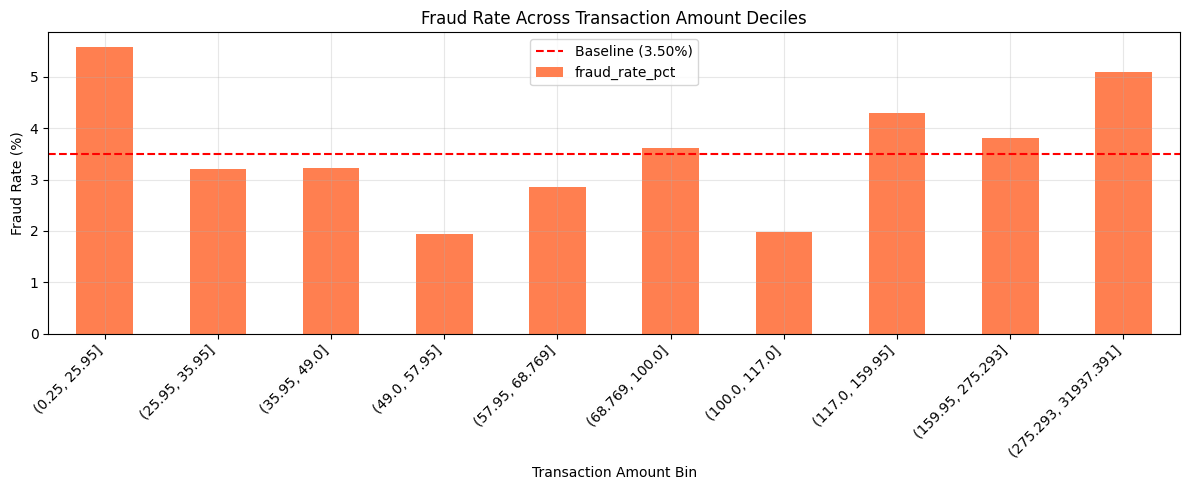

In [15]:
# Step 2C.2: Fraud Rate by Amount Bands
train["amt_bin"] = pd.qcut(
    train["TransactionAmt"],
    q=10,
    duplicates="drop"
)

fraud_by_amt = (
    train.groupby("amt_bin", observed=True)["isFraud"]
    .agg(["mean", "count"])
    .sort_index()
)
fraud_by_amt["fraud_rate_pct"] = fraud_by_amt["mean"] * 100

print("Fraud Rate by Transaction Amount Decile:")
print(fraud_by_amt)
print()

# Visualization
fig, ax = plt.subplots(figsize=(12, 5))
fraud_by_amt["fraud_rate_pct"].plot(kind="bar", ax=ax, color="coral")
ax.axhline(y=fraud_rate * 100, color="red", linestyle="--", label=f"Baseline ({fraud_rate:.2%})")
ax.set_xlabel("Transaction Amount Bin")
ax.set_ylabel("Fraud Rate (%)")
ax.set_title("Fraud Rate Across Transaction Amount Deciles")
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("../visuals/fraud_rate_by_amount_bins.png", dpi=300)
plt.show()

STEP 2D: Product-Level Risk Profiling
Fraud Rate by Product Code:
               mean   count  fraud_rate_pct
ProductCD                                  
C          0.116873   68519       11.687269
S          0.058996   11628        5.899553
H          0.047662   33024        4.766231
R          0.037826   37699        3.782594
W          0.020399  439670        2.039939



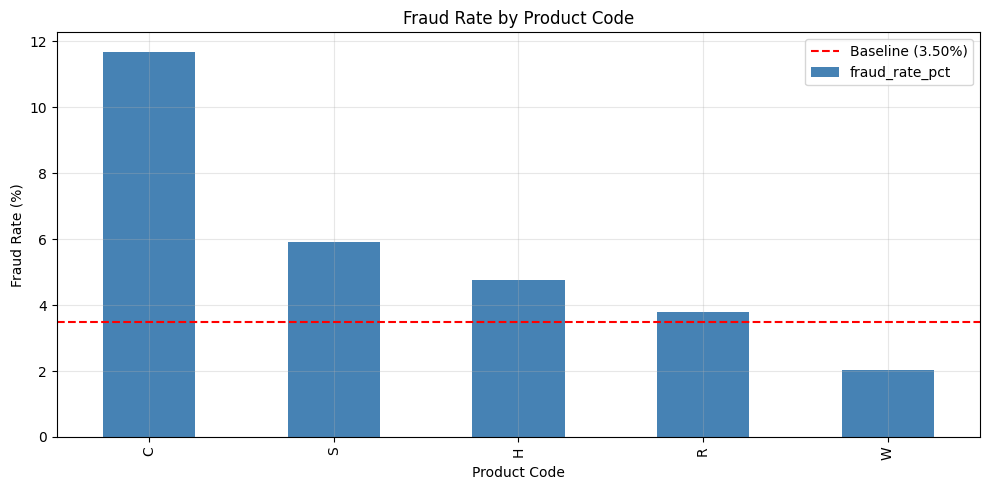

In [16]:
# Step 2D: Product-Level Risk Profiling


print("=" * 60)
print("STEP 2D: Product-Level Risk Profiling")
print("=" * 60)

fraud_by_product = (
    train.groupby("ProductCD")["isFraud"]
    .agg(["mean", "count"])
    .sort_values("mean", ascending=False)
)
fraud_by_product["fraud_rate_pct"] = fraud_by_product["mean"] * 100

print("Fraud Rate by Product Code:")
print(fraud_by_product)
print()

# Visualization
fig, ax = plt.subplots(figsize=(10, 5))
fraud_by_product["fraud_rate_pct"].plot(kind="bar", ax=ax, color="steelblue")
ax.axhline(y=fraud_rate * 100, color="red", linestyle="--", label=f"Baseline ({fraud_rate:.2%})")
ax.set_xlabel("Product Code")
ax.set_ylabel("Fraud Rate (%)")
ax.set_title("Fraud Rate by Product Code")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../visuals/fraud_rate_by_product_code.png", dpi=300)
plt.show()


STEP 2E: Payment Instrument Risk Analysis
Fraud Rate by Card Type (card4):
                      mean   count  fraud_rate_pct
card4                                             
discover          0.077282    6651        7.728161
visa              0.034756  384767        3.475610
mastercard        0.034331  189217        3.433095
american express  0.028698    8328        2.869837



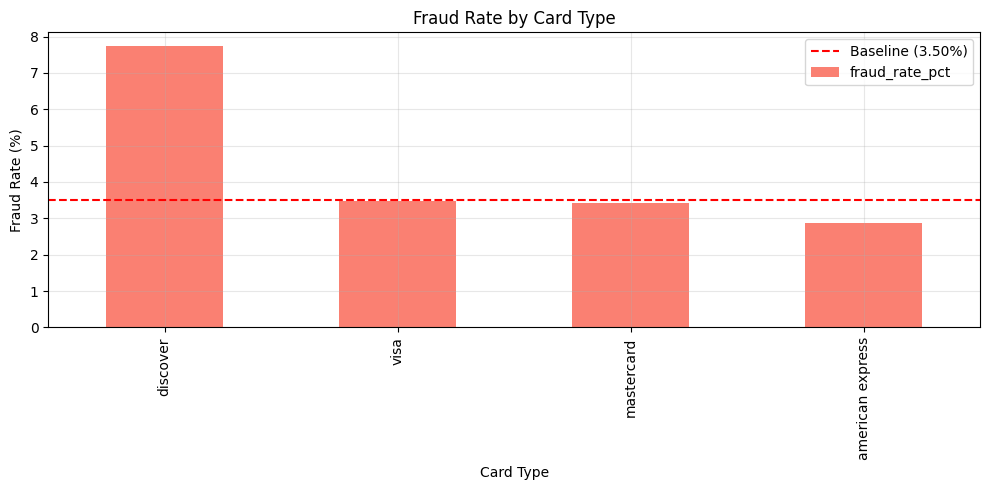

In [17]:
# Step 2E: Payment Instrument Risk (Cards)


print("=" * 60)
print("STEP 2E: Payment Instrument Risk Analysis")
print("=" * 60)

fraud_by_card = (
    train.groupby("card4")["isFraud"]
    .agg(["mean", "count"])
    .sort_values("mean", ascending=False)
)
fraud_by_card["fraud_rate_pct"] = fraud_by_card["mean"] * 100

print("Fraud Rate by Card Type (card4):")
print(fraud_by_card)
print()

# Visualization
fig, ax = plt.subplots(figsize=(10, 5))
fraud_by_card["fraud_rate_pct"].plot(kind="bar", ax=ax, color="salmon")
ax.axhline(y=fraud_rate * 100, color="red", linestyle="--", label=f"Baseline ({fraud_rate:.2%})")
ax.set_xlabel("Card Type")
ax.set_ylabel("Fraud Rate (%)")
ax.set_title("Fraud Rate by Card Type")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../visuals/fraud_rate_by_card_type.png", dpi=300)
plt.show()

STEP 2F: Email Domain Risk Profiling
Top 10 Email Domains by Fraud Rate (min 1000 transactions):
                   mean   count  fraud_rate_pct
P_emaildomain                                  
outlook.com    0.094584    5096        9.458399
hotmail.com    0.052950   45250        5.295028
gmail.com      0.043542  228355        4.354185
icloud.com     0.031434    6267        3.143450
comcast.net    0.031187    7888        3.118661
bellsouth.net  0.027763    1909        2.776323
live.com       0.027622    3041        2.762249
anonymous.com  0.023217   36998        2.321747
yahoo.com      0.022757  100934        2.275745
msn.com        0.021994    4092        2.199413



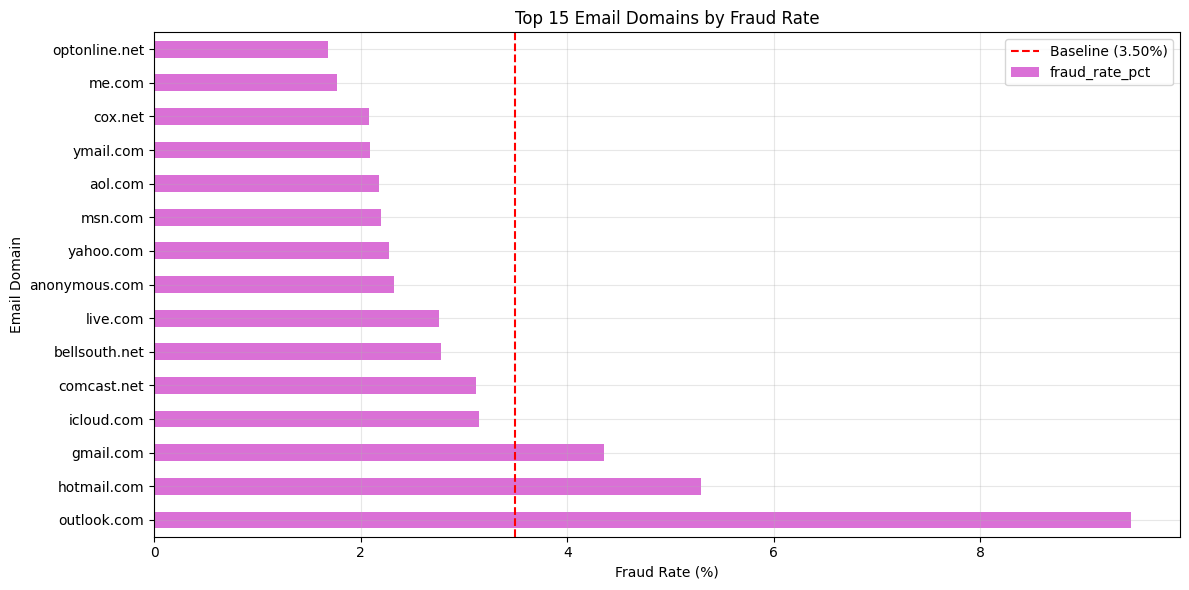

In [19]:
# Step 2F: Email Domain & Identity Risk


print("=" * 60)
print("STEP 2F: Email Domain Risk Profiling")
print("=" * 60)

fraud_by_email = (
    train.groupby("P_emaildomain")["isFraud"]
    .agg(["mean", "count"])
    .query("count > 1000")  # Filter for statistical significance
    .sort_values("mean", ascending=False)
)
fraud_by_email["fraud_rate_pct"] = fraud_by_email["mean"] * 100

print("Top 10 Email Domains by Fraud Rate (min 1000 transactions):")
print(fraud_by_email.head(10))
print()

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
fraud_by_email.head(15)["fraud_rate_pct"].plot(kind="barh", ax=ax, color="orchid")
ax.axvline(x=fraud_rate * 100, color="red", linestyle="--", label=f"Baseline ({fraud_rate:.2%})")
ax.set_xlabel("Fraud Rate (%)")
ax.set_ylabel("Email Domain")
ax.set_title("Top 15 Email Domains by Fraud Rate")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../visuals/top_15_email_domains_by_fraud_rate.png", dpi=300)
plt.show()

STEP 2G: Identity Missingness Risk Analysis
Fraud Rate by Identity Presence:
                      mean   count  fraud_rate_pct
identity_missing                                  
False             0.078470  144233        7.847025
True              0.020939  446307        2.093850

 Risk Multiplier: Transactions WITHOUT identity are 0.27x more likely to be fraud



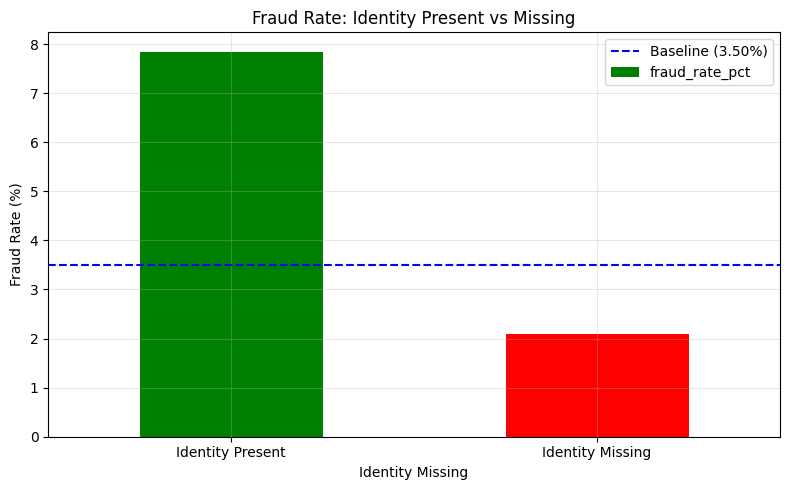

In [21]:
# Step 2G: Identity Missingness as Risk Signal


print("=" * 60)
print("STEP 2G: Identity Missingness Risk Analysis")
print("=" * 60)

# Identify identity columns
identity_cols = [c for c in train.columns if c.startswith("id_")]

# Create missing identity flag
train["identity_missing"] = train[identity_cols].isna().all(axis=1)

# Compare fraud rates
fraud_by_identity = train.groupby("identity_missing")["isFraud"].agg(["mean", "count"])
fraud_by_identity["fraud_rate_pct"] = fraud_by_identity["mean"] * 100

print("Fraud Rate by Identity Presence:")
print(fraud_by_identity)
print()

risk_ratio = (
    fraud_by_identity.loc[True, "mean"] / 
    fraud_by_identity.loc[False, "mean"]
)
print(f" Risk Multiplier: Transactions WITHOUT identity are {risk_ratio:.2f}x more likely to be fraud")
print()

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
fraud_by_identity["fraud_rate_pct"].plot(kind="bar", ax=ax, color=["green", "red"])
ax.axhline(y=fraud_rate * 100, color="blue", linestyle="--", label=f"Baseline ({fraud_rate:.2%})")
ax.set_xlabel("Identity Missing")
ax.set_ylabel("Fraud Rate (%)")
ax.set_title("Fraud Rate: Identity Present vs Missing")
ax.set_xticklabels(["Identity Present", "Identity Missing"], rotation=0)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../visuals/fraud_rate_identity_present vs missing.png", dpi=300)
plt.show()

STEP 2H: Temporal Risk Analysis
Fraud Rate by Hour of Day:
                     mean  count  fraud_rate_pct
TransactionHour                                 
0                0.031380  37795        3.137981
1                0.031314  32797        3.131384
2                0.037483  26732        3.748317
3                0.038314  20802        3.831362
4                0.051890  14839        5.189029
5                0.070302   9701        7.030203
6                0.077743   6007        7.774263
7                0.106102   3704       10.610151
8                0.093014   2591        9.301428
9                0.089956   2479        8.995563
10               0.053212   3627        5.321202
11               0.038816   6827        3.881646
12               0.030439  12451        3.043932
13               0.022889  20315        2.288949
14               0.024216  28328        2.421632
15               0.025399  33859        2.539945
16               0.029511  38698        2.951057
17        

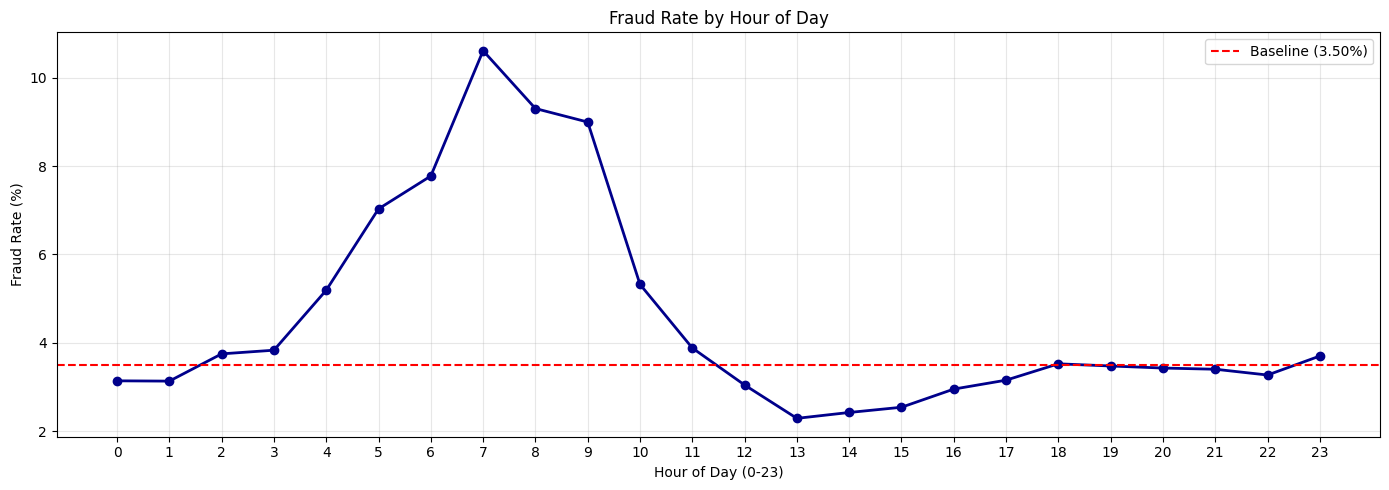


⚠️ High-risk hours (>20% above baseline):
[4, 5, 6, 7, 8, 9, 10]



In [22]:
# Step 2H: Time-Based Risk Patterns


print("=" * 60)
print("STEP 2H: Temporal Risk Analysis")
print("=" * 60)

# Calculate hour of day
train["TransactionHour"] = ((train["TransactionDT"] / 3600) % 24).astype(int)

fraud_by_hour = (
    train.groupby("TransactionHour")["isFraud"]
    .agg(["mean", "count"])
    .sort_index()
)
fraud_by_hour["fraud_rate_pct"] = fraud_by_hour["mean"] * 100

print("Fraud Rate by Hour of Day:")
print(fraud_by_hour)
print()

# Visualization
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(fraud_by_hour.index, fraud_by_hour["fraud_rate_pct"], marker="o", linewidth=2, color="darkblue")
ax.axhline(y=fraud_rate * 100, color="red", linestyle="--", label=f"Baseline ({fraud_rate:.2%})")
ax.set_xlabel("Hour of Day (0-23)")
ax.set_ylabel("Fraud Rate (%)")
ax.set_title("Fraud Rate by Hour of Day")
ax.set_xticks(range(24))
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../visuals/fraud_rate_by_hour_of_day.png", dpi=300)
plt.show()

# Identify high-risk hours
high_risk_hours = fraud_by_hour[fraud_by_hour["fraud_rate_pct"] > fraud_rate * 100 * 1.2]
print(f"\n⚠️ High-risk hours (>20% above baseline):")
print(high_risk_hours.index.tolist())
print()

In [12]:
# Step 2I: Summary Report


print("=" * 60)
print("STEP 2I: Risk Profiling Summary Report")
print("=" * 60)

summary = {
    "Overall Fraud Rate": f"{fraud_rate:.4%}",
    "Total Transactions": f"{len(train):,}",
    "Fraudulent Transactions": f"{fraud_count:,}",
    "High-Risk Products": fraud_by_product.head(1).index.tolist(),
    "High-Risk Card Types": fraud_by_card.head(1).index.tolist(),
    "High-Risk Email Domains": fraud_by_email.head(3).index.tolist(),
    "Identity Missing Risk": f"{risk_ratio:.2f}x higher",
    "High-Risk Hours": high_risk_hours.index.tolist()
}

print("\n📋 Key Findings:")
for key, value in summary.items():
    print(f"   {key}: {value}")

print("\n" + "=" * 60)
print("🎯 Step 2 completed successfully!")
print("   Next: Step 3 - Feature Engineering")
print("=" * 60)

STEP 2I: Risk Profiling Summary Report

📋 Key Findings:
   Overall Fraud Rate: 3.4990%
   Total Transactions: 590,540
   Fraudulent Transactions: 20,663
   High-Risk Products: ['C']
   High-Risk Card Types: ['discover']
   High-Risk Email Domains: ['outlook.com', 'hotmail.com', 'gmail.com']
   Identity Missing Risk: 0.27x higher
   High-Risk Hours: [4, 5, 6, 7, 8, 9, 10]

🎯 Step 2 completed successfully!
   Next: Step 3 - Feature Engineering
